In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf


In [3]:
ISBG = pd.read_excel("./data/ISBSG-whole.xlsx",header=3)

In [4]:
cols_needed = ['Max Team Size','COSMIC Read','COSMIC Write','COSMIC Entry','COSMIC Exit','Project Elapsed Time','Development Platform','Primary Programming Language','Summary Work Effort']
ISBG_interest = ISBG[cols_needed]
print(len(ISBG_interest))
df_clean = ISBG_interest.dropna(subset=["COSMIC Read", "COSMIC Write", "COSMIC Exit", "COSMIC Entry","Summary Work Effort"])
print(len(df_clean))

5957
253


In [5]:
LOG_INPUT_OFF = False

OUTLIER_REMOVAL = False

RANDOM_SEED = 42


In [6]:
cmp = sns.cubehelix_palette(start=2, rot=0, dark=0, light=.95, reverse=True, as_cmap=True)

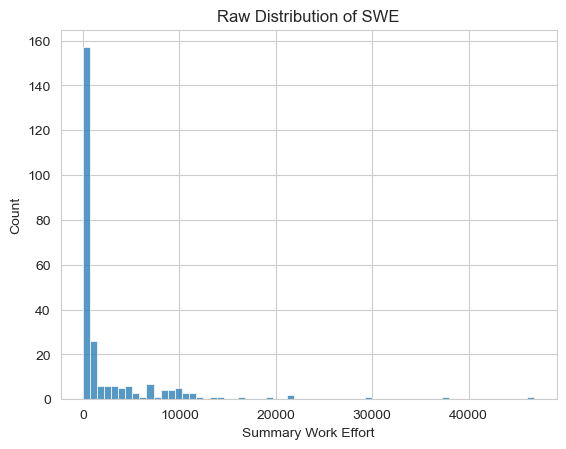

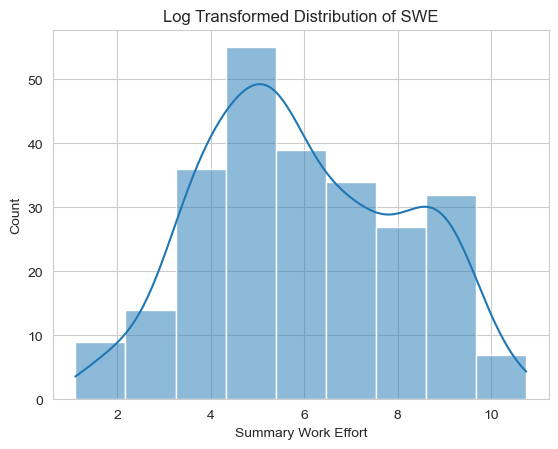

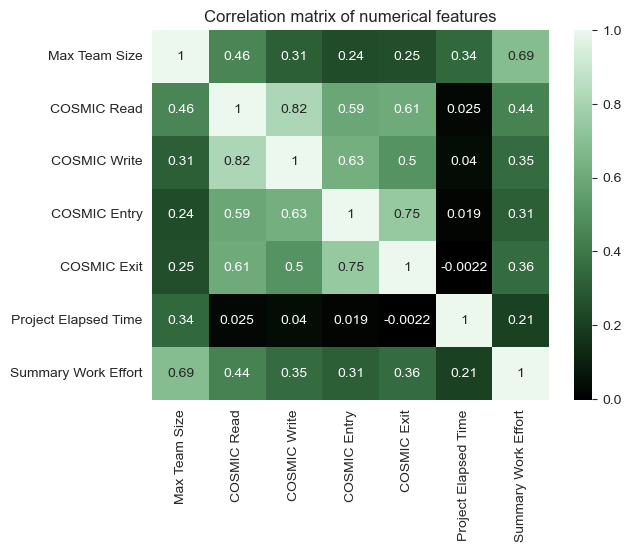

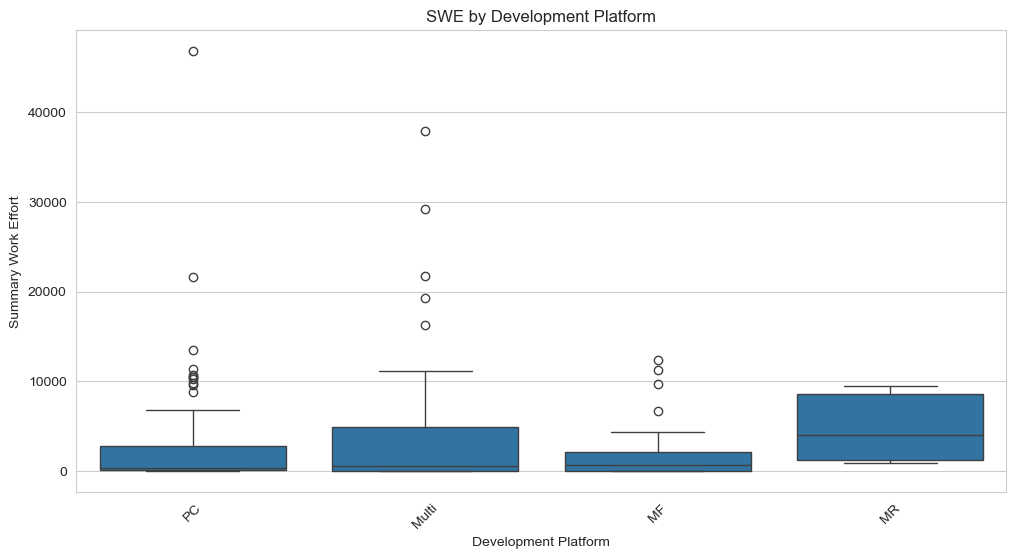

In [7]:
y_clean = df_clean["Summary Work Effort"]



import pandas as pd

plt.figure()
plt.title("Raw Distribution of SWE")
sns.histplot(y_clean)
plt.show()
plt.figure()
plt.title("Log Transformed Distribution of SWE")
sns.histplot(np.log1p(y_clean),kde=True)
plt.show()

corr = df_clean.select_dtypes(include='number').corr()
plt.figure()
plt.title("Correlation matrix of numerical features")

sns.heatmap(corr, annot=True, cmap=cmp)
plt.show()

# sns.pairplot(df_clean)
plt.figure(figsize=(12,6))
sns.boxplot(
    data=df_clean,
    x="Development Platform",
    y="Summary Work Effort",
)
plt.xticks(rotation=45)
plt.title("SWE by Development Platform")
plt.show()



In [8]:
# Assuming your DataFrame is named df_clean (or replace with your DataFrame variable)

# 1. Get the count of missing values per column
missing_counts = df_clean.isnull().sum()

# 2. (Optional) Also get the percentage of missing values per column
missing_pct = df_clean.isnull().mean() * 100

# 3. Combine into a single DataFrame for a neat display
missing_summary = pd.DataFrame({
    'missing_count': missing_counts,
    'missing_pct': missing_pct
})

print(missing_summary)

def drop_iqr_outliers(df, cols):
    for c in cols:
        Q1  = df[c].quantile(0.25)
        Q3  = df[c].quantile(0.75)
        IQR = Q3 - Q1
        df  = df[(df[c] >= Q1 - 1.5*IQR) & (df[c] <= Q3 + 1.5*IQR)]
    return df

if OUTLIER_REMOVAL:
    df_clean = drop_iqr_outliers(df_clean, ["Summary Work Effort"])
    len(df_clean["Summary Work Effort"])


                              missing_count  missing_pct
Max Team Size                            86    33.992095
COSMIC Read                               0     0.000000
COSMIC Write                              0     0.000000
COSMIC Entry                              0     0.000000
COSMIC Exit                               0     0.000000
Project Elapsed Time                     20     7.905138
Development Platform                     60    23.715415
Primary Programming Language             16     6.324111
Summary Work Effort                       0     0.000000


In [9]:
len(df_clean["Summary Work Effort"])

253

In [33]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.impute import KNNImputer, SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import FunctionTransformer, StandardScaler, OneHotEncoder, MinMaxScaler


X_clean = df_clean.drop(columns=["Summary Work Effort"])
y_clean = df_clean["Summary Work Effort"]

X_train, X_test, y_train, y_test = train_test_split(
    X_clean, y_clean, test_size=0.2, random_state=RANDOM_SEED
)

y_train_log = np.log1p(y_train)
y_test_log = np.log1p(y_test)
y_test = np.log1p(y_test)

all_numeric_cols = X_train.select_dtypes(include=np.number).columns.tolist()
all_categorical_cols = X_train.select_dtypes(exclude=np.number).columns.tolist()

tech_features_orig = ["Development Platform", "Primary Programming Language",
                      "Project Elapsed Time", "Max Team Size"]

functional_features_orig = ["COSMIC Read", "COSMIC Write", "COSMIC Entry",
                            "COSMIC Exit"]


numeric_pipeline_steps = [
    ('imputer', KNNImputer(n_neighbors=5)),
    ('log1p', FunctionTransformer(np.log1p, validate=False, feature_names_out='one-to-one')),
    ('scaler', MinMaxScaler()),
]


numeric_pipeline = Pipeline(numeric_pipeline_steps)
categorical_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])


tech_num_cols = [col for col in tech_features_orig if col in all_numeric_cols]
tech_cat_cols = [col for col in tech_features_orig if col in all_categorical_cols]
func_num_cols = [col for col in functional_features_orig if col in all_numeric_cols]
func_cat_cols = [col for col in functional_features_orig if col in all_categorical_cols]

numeric_cols_for_preprocessing = tech_num_cols + func_num_cols
categorical_cols_for_preprocessing = tech_cat_cols + func_cat_cols

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_pipeline, numeric_cols_for_preprocessing),
        ('cat', categorical_pipeline, categorical_cols_for_preprocessing)
    ],
)

X_train_prepared = preprocessor.fit_transform(X_train)
X_test_prepared = preprocessor.transform(X_test)

feature_names_out = preprocessor.get_feature_names_out()

X_train_prepared_df = pd.DataFrame(X_train_prepared, columns=feature_names_out, index=X_train.index)
X_test_prepared_df = pd.DataFrame(X_test_prepared, columns=feature_names_out, index=X_test.index)

tech_prepared_cols = []
func_prepared_cols = []


# Thanks to chatgpt for this piece:
for col_name in feature_names_out:
    parts = col_name.split('__')
    if len(parts) > 1:
        original_feature = parts[1].split('_')[0] # Basic extraction, might need refinement if feature names contain underscores
        # More robust extraction if needed:
        # Check if original_feature exists in numeric/categorical lists before assigning
        if parts[0] == 'num': # Check if it came from the numeric pipeline
             # Find the original name (assuming it's the second part)
             original_feature = parts[1]
        elif parts[0] == 'cat': # Check if it came from the categorical pipeline
             # OneHotEncoder adds the category value, find the base feature name
             # Find the original feature name that this encoded column belongs to
             original_feature = next((cat_col for cat_col in categorical_cols_for_preprocessing if col_name.startswith(f"cat__{cat_col}_")), None)
             if original_feature is None and col_name.split('__')[1] in categorical_cols_for_preprocessing:
                  # Handle cases where OHE might not add _category (e.g., binary features, drop='if_binary') - less common with sparse_output=False
                  original_feature = col_name.split('__')[1]

        if original_feature in tech_features_orig:
            tech_prepared_cols.append(col_name)
        elif original_feature in functional_features_orig:
            func_prepared_cols.append(col_name)

X_train_tech = X_train_prepared_df[tech_prepared_cols]
X_test_tech = X_test_prepared_df[tech_prepared_cols]

X_train_func = X_train_prepared_df[func_prepared_cols]
X_test_func = X_test_prepared_df[func_prepared_cols]

print("\n Separate datasets for tech and func features:")
print("Shape of X_train_tech:", X_train_tech.shape)
print("Shape of X_test_tech:", X_test_tech.shape)
print("Shape of X_train_func:", X_train_func.shape)
print("Shape of X_test_func:", X_test_func.shape)



 Separate datasets for tech and func features:
Shape of X_train_tech: (202, 25)
Shape of X_test_tech: (51, 25)
Shape of X_train_func: (202, 4)
Shape of X_test_func: (51, 4)


### Marias prepro:

254
KS statistic: 0.1296, p-value: 0.4582

 Separate datasets for tech and func features:
Shape of X_train_tech: (202, 10)
Shape of X_test_tech: (51, 10)
Shape of X_train_func: (202, 4)
Shape of X_test_func: (51, 4)


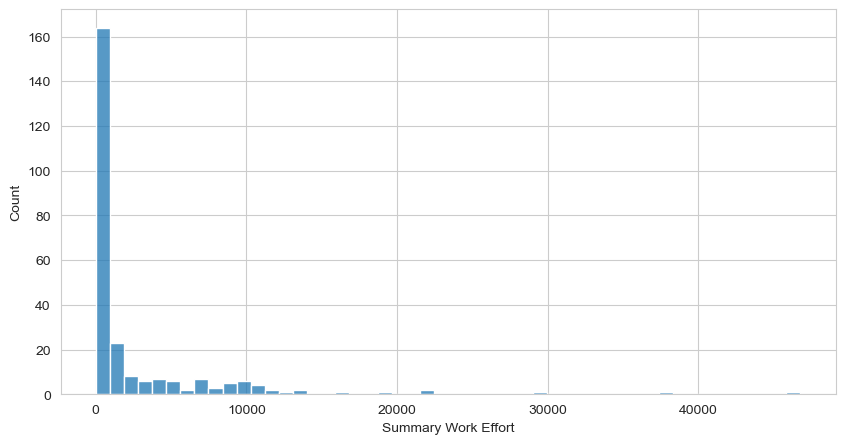

In [41]:
### MARIAS CODE

# Importing ISBG as dataframe
ISBG = pd.read_excel("./data/ISBSG-whole.xlsx",header=3)
# ISBG.set_index("Project ID", inplace=True)

cols_needed = ['Max Team Size','COSMIC Read','COSMIC Write','COSMIC Entry','COSMIC Exit','Project Elapsed Time','Development Platform','Primary Programming Language','Summary Work Effort']
ISBG_interest = ISBG[cols_needed]
ISBG_interest.head()

df_clean = ISBG_interest.dropna(subset=["COSMIC Read", "COSMIC Write", "COSMIC Exit", "COSMIC Entry"])
print(len(df_clean))
plt.figure(figsize=(10,5))
sns.histplot(df_clean['Summary Work Effort'], kde=False, bins=50)  # Set bins and kde to False

df_clean = df_clean.dropna(subset=['Summary Work Effort'])

from sklearn.model_selection import train_test_split

X_clean = df_clean.drop(columns=["Summary Work Effort"])
y_clean = df_clean["Summary Work Effort"]
X_train, X_test, y_train, y_test = train_test_split(
    X_clean, y_clean, test_size=0.2, random_state=42
)

from scipy.stats import ks_2samp

stat, p = ks_2samp(y_train, y_test)
print(f'KS statistic: {stat:.4f}, p-value: {p:.4f}')
# Median imputation for numerical columns
for col in X_train.select_dtypes(include=['float64', 'int64']).columns:
    median_value = X_train[col].median()
    X_train[col] = X_train[col].fillna(median_value)
    X_test[col] = X_test[col].fillna(median_value)

# Mode imputation for categorical columns
for col in X_train.select_dtypes(include=['object']).columns:
    mode_value = X_train[col].mode()[0]
    X_train[col] = X_train[col].fillna(mode_value)
    X_test[col] = X_test[col].fillna(mode_value)

# Log transformation for skewed numerical columns
skewed = ["COSMIC Read", "COSMIC Write", "COSMIC Entry", "COSMIC Exit", "Max Team Size"]
for col in skewed:
    X_train[col] = np.log1p(X_train[col])
    X_test[col] = np.log1p(X_test[col])

# Log transform output variable
y_train = np.log1p(y_train)
y_test = np.log1p(y_test)

# Min-max scaling for numerical columns
from sklearn.preprocessing import MinMaxScaler
numeric_cols = X_train.select_dtypes(include=['float64', 'int64']).columns
scaler = MinMaxScaler()
X_train[numeric_cols] = scaler.fit_transform(X_train[numeric_cols])
X_test[numeric_cols] = scaler.transform(X_test[numeric_cols])

# Threshold: keep only the top N most frequent languages
top_langs = X_train['Primary Programming Language'].value_counts().nlargest(5).index

# Replace rare languages with 'Other' in both train and test
X_train['Primary Programming Language'] = X_train['Primary Programming Language'].apply(
    lambda x: x if x in top_langs else 'Other'
)
X_test['Primary Programming Language'] = X_test['Primary Programming Language'].apply(
    lambda x: x if x in top_langs else 'Other'
)

# One-hot encoding for categorical columns
X_train = pd.get_dummies(X_train, drop_first=True)
X_test = pd.get_dummies(X_test, drop_first=True)

# Align test set to train set
X_train, X_test = X_train.align(X_test, join='left', axis=1, fill_value=0)

#Split into functioal and technical features
X_train_func = X_train[["COSMIC Read", "COSMIC Write", "COSMIC Entry", "COSMIC Exit"]]
X_train_tech = X_train.drop(columns=["COSMIC Read", "COSMIC Write", "COSMIC Entry", "COSMIC Exit"])
X_test_func = X_test[["COSMIC Read", "COSMIC Write", "COSMIC Entry", "COSMIC Exit"]]
X_test_tech = X_test.drop(columns=["COSMIC Read", "COSMIC Write", "COSMIC Entry", "COSMIC Exit"])
print("\n Separate datasets for tech and func features:")
print("Shape of X_train_tech:", X_train_tech.shape)
print("Shape of X_test_tech:", X_test_tech.shape)
print("Shape of X_train_func:", X_train_func.shape)
print("Shape of X_test_func:", X_test_func.shape)

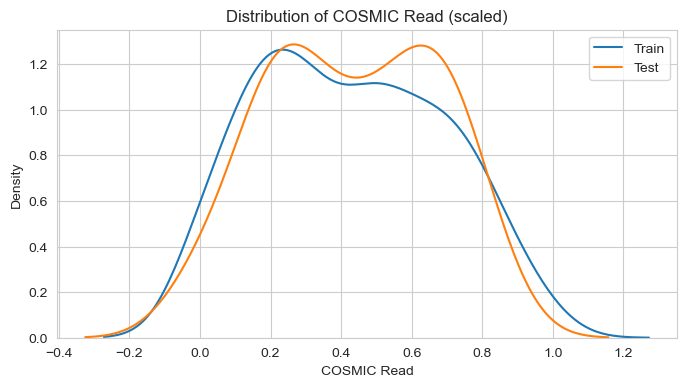

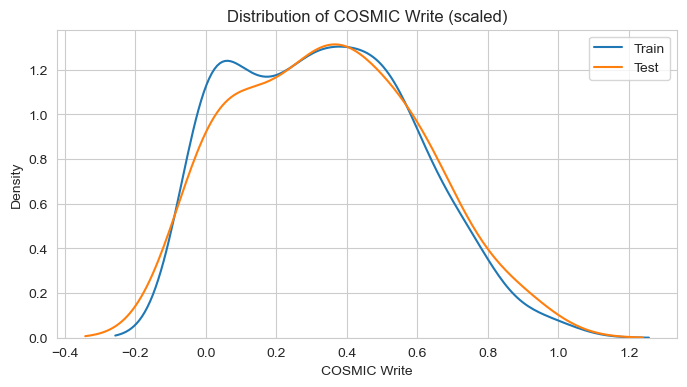

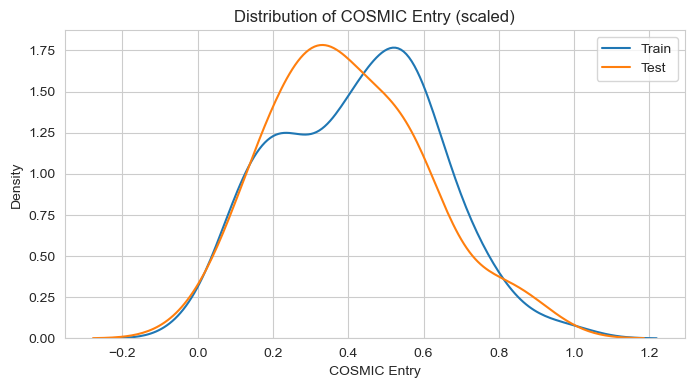

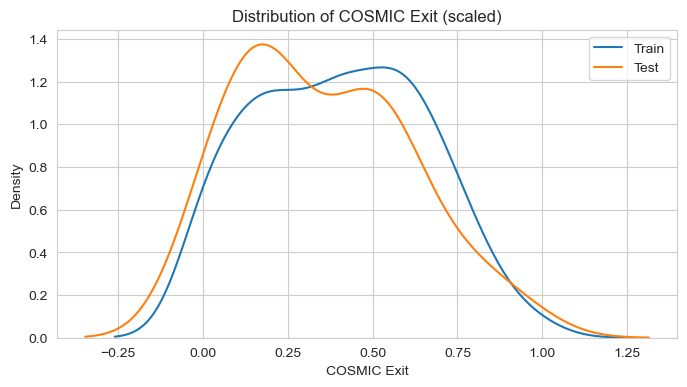

KeyError: 'Max Team Size'

<Figure size 800x400 with 0 Axes>

In [42]:
def compare_feature_distribution(feature_name):
    plt.figure(figsize=(8, 4))
    sns.kdeplot(X_train_func[feature_name], label='Train')
    sns.kdeplot(X_test_func[feature_name], label='Test')
    plt.title(f'Distribution of {feature_name} (scaled)')
    plt.legend()
    plt.show()

compare_feature_distribution('COSMIC Read')
compare_feature_distribution('COSMIC Write')
compare_feature_distribution('COSMIC Entry')
compare_feature_distribution('COSMIC Exit')
compare_feature_distribution('Max Team Size')
compare_feature_distribution('Project Elapsed Time')

In [43]:
from sklearn.model_selection import cross_validate
from sklearn.metrics import make_scorer, mean_absolute_error, mean_squared_error, r2_score
# Define scoring metrics
scoring = {
    'r2': 'r2',
    'mae': make_scorer(mean_absolute_error),
    'mse': make_scorer(mean_squared_error),
}
def evaluate_model(X_train, y_train, X_test, y_test, model, label=""):

    # Cross-validation
    cv_results = cross_validate(model, X_train, y_train, cv=10, scoring=scoring, return_train_score=False)

    print(f"\n--- {label} (Cross-Validation on Train Set) ---")
    for metric in scoring:
        scores = cv_results[f'test_{metric}']
        print(f"{metric.upper()} (mean ± std): {scores.mean():.4f} ± {scores.std():.4f}")

    # Fit on full training set and evaluate on test set
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    print(f"\n--- {label} (Test Set) ---")
    print(f"R2:  {r2_score(y_test, y_pred):.4f}")
    print(f"MAE: {mean_absolute_error(y_test, y_pred):.4f}")
    print(f"MSE: {mean_squared_error(y_test, y_pred):.4f}")

In [30]:
import xgboost as xgboost
from sklearn.tree import DecisionTreeRegressor
import tensorflow as tf
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
print(f"True mean of SWE {df_clean['Summary Work Effort'].mean()} standard_deviation SWE {df_clean['Summary Work Effort'].std()}\n")

DTR = DecisionTreeRegressor(random_state=RANDOM_SEED)

dtr_model_tech = DTR.fit(X_train_tech,y_train_log)
dtr_pred_log_tech = dtr_model_tech.predict(X_test_tech)
results_dtr_tech = evaluate_model("DTR_tech",y_test,dtr_pred_log_tech)

dtr_model_func = DTR.fit(X_train_func,y_train_log)
dtr_pred_log_func = dtr_model_func.predict(X_test_func)
results_dtr_func = evaluate_model("DTR_func",y_test,dtr_pred_log_func)

xgb = xgboost.XGBRegressor(objective="reg:squarederror",random_state=RANDOM_SEED)

xgb_model_tech = xgb.fit(X_train_tech,y_train_log)
xgb_pred_log_tech = xgb_model_tech.predict(X_test_tech)
results_xgb_tech = evaluate_model("XGB_tech",y_test,xgb_pred_log_tech)

xgb_model_func = xgb.fit(X_train_func,y_train_log)
xgb_pred_log_func = xgb_model_func.predict(X_test_func)
results_xgb_func = evaluate_model("XGB_func",y_test,xgb_pred_log_func)

predictions = [(dtr_pred_log_tech,"DTR_tech"),(dtr_pred_log_func,"DTR_func"),(xgb_pred_log_tech,"XGB_tech"),(xgb_pred_log_func,"XGB_func")]


evaluate_model2(X_train_tech, y_train, X_test_tech, y_test,xgb_model_tech, label="XGB Technical")
evaluate_model2(X_train_func, y_train, X_test_func, y_test,xgb_model_func, label="XGB Functional")


True mean of SWE 2545.9723320158105 standard_deviation SWE 5514.492199421938


Model: DTR_tech, mse : 50636970.380339116, r2 : -10223518.903858172, mae : 3152.408891726137, rmse 7115.965878244437

Model: DTR_func, mse : 11260739.517018877, r2 : -2273523.5359209767, mae : 1637.4699711993126, rmse 3355.7025370284055

Model: XGB_tech, mse : 32487881.305367976, r2 : -6559248.075623448, mae : 2910.8070294876575, rmse 5699.814146563726

Model: XGB_func, mse : 5289200.316041058, r2 : -1067879.726283225, mae : 1304.7467224897973, rmse 2299.8261490906348

--- XGB Technical (Cross-Validation on Train Set) ---
R2 (mean ± std): 0.3059 ± 0.3789
MAE (mean ± std): 1669.6710 ± 998.8776
MSE (mean ± std): 16959577.2630 ± 18756244.5695

--- XGB Technical (Test Set) ---
R2:  -4952803.4563
MAE: 2833.2578
MSE: 24531180.5438

--- XGB Functional (Cross-Validation on Train Set) ---
R2 (mean ± std): -0.7370 ± 1.1649
MAE (mean ± std): 2450.7242 ± 640.8471
MSE (mean ± std): 24862008.4619 ± 16987686.2779

--- XGB 

In [37]:
def pred_act(y_test,y_pred,label):
    plt.figure()
    plt.title(label)
    plt.scatter(y_test,y_pred)
    max_val = y_test.max()
    min_val = y_test.min()
    plt.plot([min_val,max_val],[min_val,max_val], 'r--',alpha=0.5,label=f"Perfect fit")
    plt.xlabel("y_test")
    plt.ylabel("y_pred")
    plt.savefig(f"./res/plots/{label}_test_pred.png")
    plt.show()

# for prediction in predictions:
#     y_pred = np.expm1(prediction[0])
#     pred_act(y_test,y_pred,prediction[1])

Best DTR tech: {'max_depth': None, 'min_samples_leaf': 4, 'min_samples_split': 10}
Best DTR func: {'max_depth': 4, 'min_samples_leaf': 8, 'min_samples_split': 2}
Best XGB tech: {'learning_rate': 0.2, 'max_depth': 4, 'n_estimators': 100, 'subsample': 0.8}
Best XGB func: {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 300, 'subsample': 0.8}

=== Final test performance (after grid search) ===

Model: DTR_tech (GS), mse : 457874.4630452989, r2 : 0.3618761684652595, mae : 367.60261215224807, rmse 676.6642173525204

Model: DTR_func (GS), mse : 669595.5753034473, r2 : 0.06680776374927, mae : 418.3683739496768, rmse 818.2881981939171

Model: XGB_tech (GS), mse : 345048.5870174129, r2 : 0.519117696696231, mae : 305.3849902707477, rmse 587.4083647833191

Model: XGB_func (GS), mse : 553881.7926410002, r2 : 0.2280740677550337, mae : 350.2066344327705, rmse 744.2323512458997


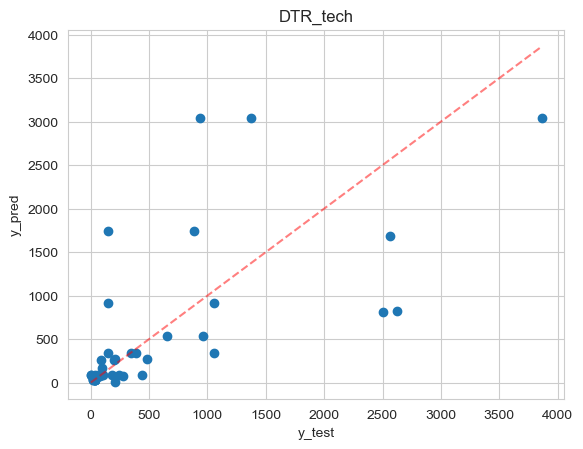

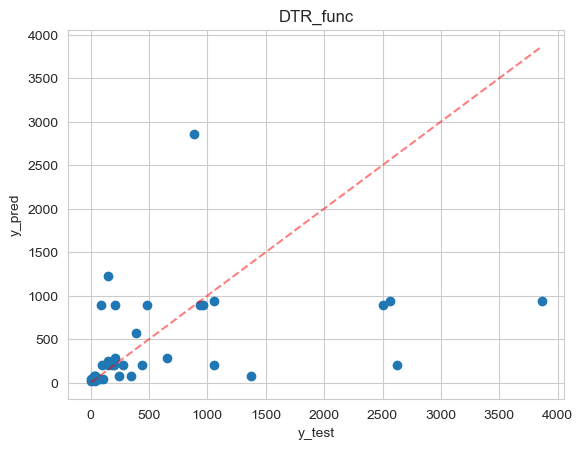

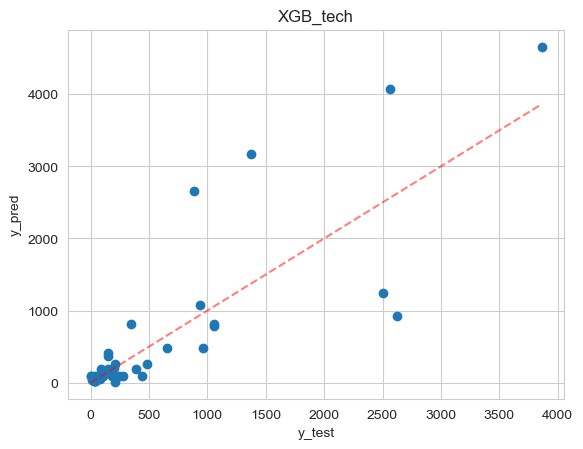

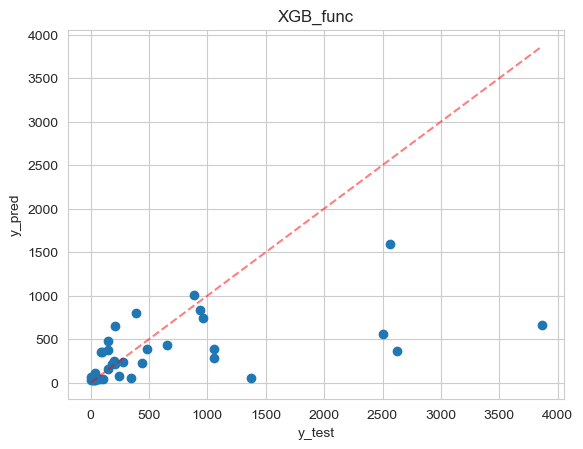

In [38]:
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeRegressor
import xgboost as xgb

param_grid_dtr = {
    'max_depth':      [None, 3,4, 5,6,7,8,9, 10],
    'min_samples_split':  [2, 5, 10, 20],
    'min_samples_leaf':   [1, 2, 4, 8],
}

param_grid_xgb = {
    'n_estimators':   [100, 200, 300,400,500],
    'max_depth':      [None, 3,4, 5,6,7,8,9, 10],
    'learning_rate':  [0.01, 0.1, 0.2],
    'subsample':      [0.8, 1.0]
}

# Decision Tree on tech features
grid_dtr_tech = GridSearchCV(
    DecisionTreeRegressor(random_state=RANDOM_SEED),
    param_grid=param_grid_dtr,
    cv=3,
    scoring='neg_mean_squared_error',
    n_jobs=-1
)
grid_dtr_tech.fit(X_train_tech, y_train_log)

# Decision Tree on func features
grid_dtr_func = GridSearchCV(
    DecisionTreeRegressor(random_state=RANDOM_SEED),
    param_grid=param_grid_dtr,
    cv=3,
    scoring='neg_mean_squared_error',
    n_jobs=-1
)
grid_dtr_func.fit(X_train_func, y_train_log)

# XGB on tech features
grid_xgb_tech = GridSearchCV(
    xgb.XGBRegressor(objective="reg:squarederror", random_state=RANDOM_SEED),
    param_grid=param_grid_xgb,
    cv=3,
    scoring='neg_mean_squared_error',
    n_jobs=-1
)
grid_xgb_tech.fit(X_train_tech, y_train_log)

# XGB on func features
grid_xgb_func = GridSearchCV(
    xgb.XGBRegressor(objective="reg:squarederror", random_state=RANDOM_SEED),
    param_grid=param_grid_xgb,
    cv=3,
    scoring='neg_mean_squared_error',
    n_jobs=-1
)
grid_xgb_func.fit(X_train_func, y_train_log)

print("Best DTR tech:", grid_dtr_tech.best_params_)
print("Best DTR func:", grid_dtr_func.best_params_)
print("Best XGB tech:", grid_xgb_tech.best_params_)
print("Best XGB func:", grid_xgb_func.best_params_)

best_dtr_tech = grid_dtr_tech.best_estimator_
best_dtr_func = grid_dtr_func.best_estimator_
best_xgb_tech = grid_xgb_tech.best_estimator_
best_xgb_func = grid_xgb_func.best_estimator_

dtr_tech_pred = best_dtr_tech.predict(X_test_tech)
dtr_func_pred = best_dtr_func.predict(X_test_func)
xgb_tech_pred = best_xgb_tech.predict(X_test_tech)
xgb_func_pred = best_xgb_func.predict(X_test_func)

print("\n=== Final test performance (after grid search) ===")
evaluate_model("DTR_tech (GS)", y_test, dtr_tech_pred)
evaluate_model("DTR_func (GS)", y_test, dtr_func_pred)
evaluate_model("XGB_tech (GS)", y_test, xgb_tech_pred)
evaluate_model("XGB_func (GS)", y_test, xgb_func_pred)


predictions2 = [(dtr_tech_pred,"DTR_tech"),(dtr_func_pred,"DTR_func"),(xgb_tech_pred,"XGB_tech"),(xgb_func_pred,"XGB_func")]

for prediction in predictions2:
    pred_act(y_test,np.expm1(prediction[0]),prediction[1])


In [50]:
evaluate_model("DTR_tech (GS)", y_test, dtr_tech_pred)
evaluate_model("DTR_func (GS)", y_test, dtr_func_pred)
evaluate_model("XGB_tech (GS)", y_test, xgb_tech_pred)
evaluate_model("XGB_func (GS)", y_test, xgb_func_pred)


Model: DTR_tech (GS), mse : 457874.4630452989, r2 : 0.3618761684652595, mae : 367.60261215224807, rmse 676.6642173525204

Model: DTR_func (GS), mse : 669595.5753034473, r2 : 0.06680776374927, mae : 418.3683739496768, rmse 818.2881981939171

Model: XGB_tech (GS), mse : 345048.5870174129, r2 : 0.519117696696231, mae : 305.3849902707477, rmse 587.4083647833191

Model: XGB_func (GS), mse : 553881.7926410002, r2 : 0.2280740677550337, mae : 350.2066344327705, rmse 744.2323512458997


(553881.7926410002, 0.2280740677550337, 350.2066344327705)

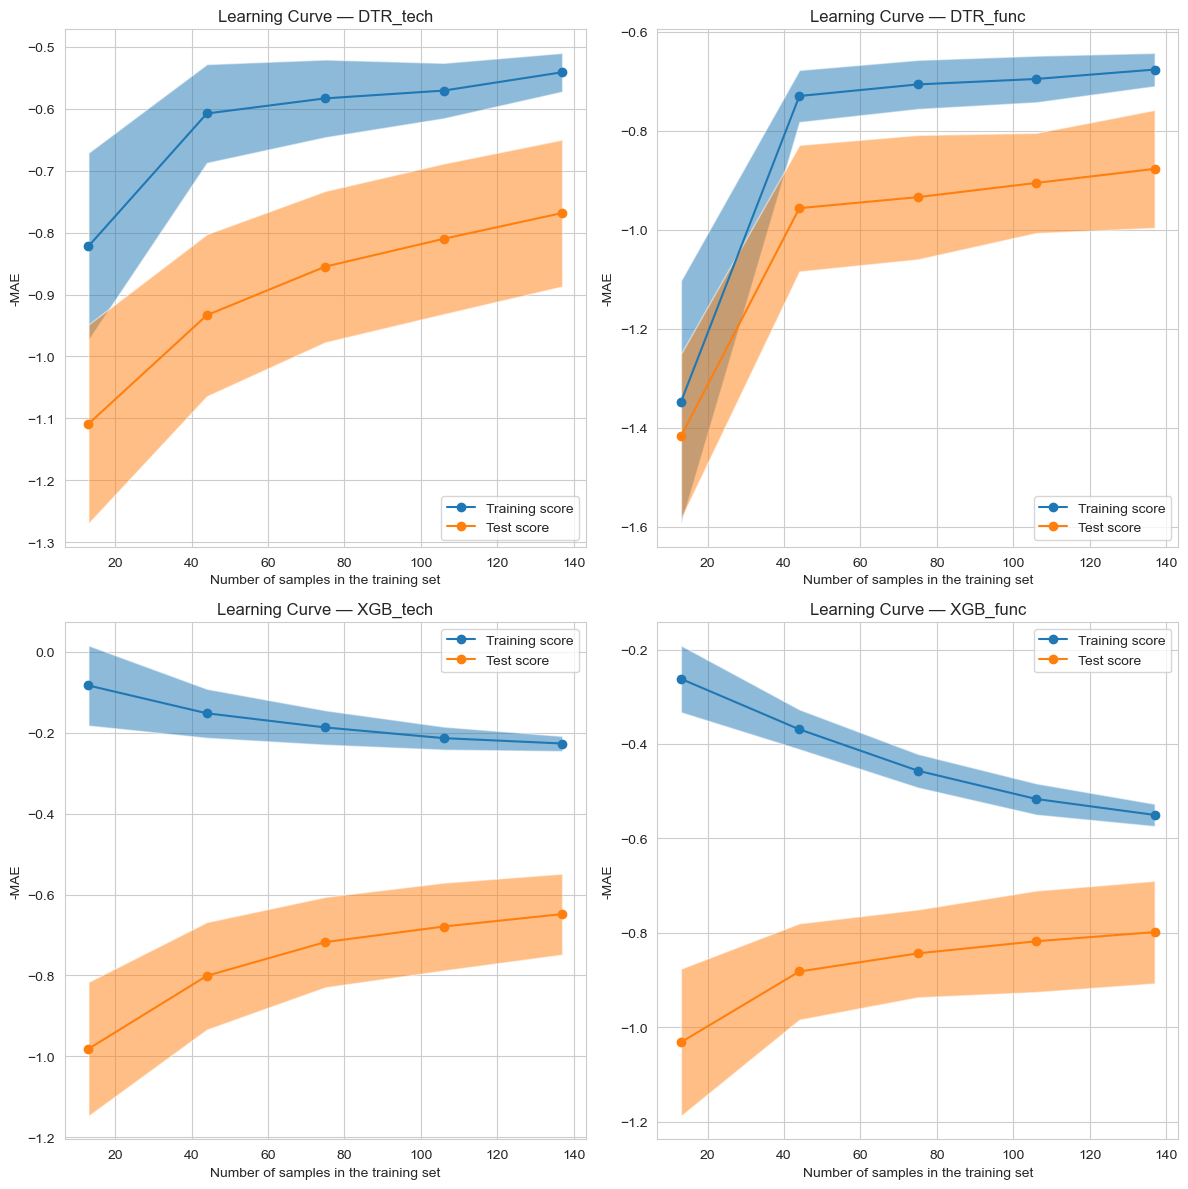

In [39]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import LearningCurveDisplay, ShuffleSplit

train_sizes = np.linspace(0.1, 1.0, 5)
cv = ShuffleSplit(n_splits=50, test_size=0.2, random_state=42)

common_params = {
    "train_sizes": train_sizes,
    "cv": cv,
    "scoring": "neg_mean_absolute_error",
    "n_jobs": -1,
    "line_kw": {"marker": "o"},
    "std_display_style": "fill_between",
    "score_type": "both",
    "score_name": "-MAE",
}

fig, axes = plt.subplots(2, 2, figsize=(12, 12))

# Top‐left: Decision Tree on tech features
LearningCurveDisplay.from_estimator(
    best_dtr_tech,
    X=X_train_tech,
    y=y_train_log,
    **common_params,
    ax=axes[0, 0]
)
axes[0, 0].set_title("Learning Curve — DTR_tech")

# Top‐right: Decision Tree on func features
LearningCurveDisplay.from_estimator(
    best_dtr_func,
    X=X_train_func,
    y=y_train_log,
    **common_params,
    ax=axes[0, 1]
)
axes[0, 1].set_title("Learning Curve — DTR_func")

# Bottom‐left: XGBoost on tech features
LearningCurveDisplay.from_estimator(
    best_xgb_tech,
    X=X_train_tech,
    y=y_train_log,
    **common_params,
    ax=axes[1, 0]
)
axes[1, 0].set_title("Learning Curve — XGB_tech")

# Bottom‐right: XGBoost on func features
LearningCurveDisplay.from_estimator(
    best_xgb_func,
    X=X_train_func,
    y=y_train_log,
    **common_params,
    ax=axes[1, 1]
)
axes[1, 1].set_title("Learning Curve — XGB_func")

# Add a single legend to each subplot
for ax in axes.ravel():
    ax.legend(["Training score", "Test score"])

plt.tight_layout()
plt.savefig("./res/plots/LearningCurveDTRXGB.png")
plt.show()


Fitting 5 folds for each of 1080 candidates, totalling 5400 fits
Best MAE (neg): -0.7472316120760609
Best hyperparameters: {'activation': 'relu', 'alpha': 0.01, 'batch_size': 16, 'early_stopping': True, 'hidden_layer_sizes': (16, 16), 'learning_rate': 'constant', 'learning_rate_init': 0.01, 'solver': 'adam', 'validation_fraction': 0.2}

Model: MLP_tech_sklearn, mse : 36352278.23707048, r2 : -49.66291515664066, mae : 1672.9078024206697, rmse 6029.285051900472
Fitting 5 folds for each of 1080 candidates, totalling 5400 fits
Best MAE (neg): -0.9125748792364247
Best hyperparameters: {'activation': 'relu', 'alpha': 0.01, 'batch_size': 8, 'early_stopping': True, 'hidden_layer_sizes': (32, 16, 8), 'learning_rate': 'constant', 'learning_rate_init': 0.001, 'solver': 'adam', 'validation_fraction': 0.2}

Model: MLP_func_sklearn, mse : 563598.3973509549, r2 : 0.21453237122584468, mae : 384.5611459924704, rmse 750.7319077746429


C:\Users\Janvg\miniconda3\envs\ResearchWorkshop\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


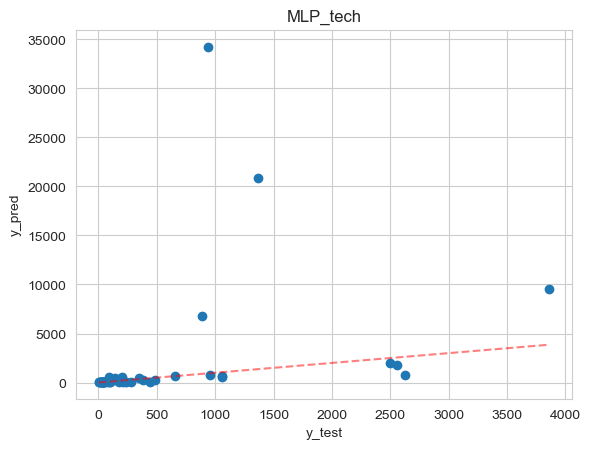

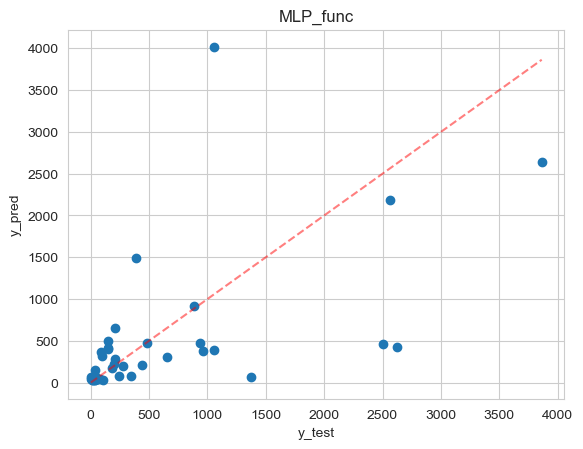

In [40]:
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import mean_absolute_error


mlp = MLPRegressor(
    random_state=RANDOM_SEED+10,
    early_stopping=True,      # turn on early stopping
    validation_fraction=0.1,  # fraction of train used as internal val set
    n_iter_no_change=10,      # stop if no improvement in 10 epochs
    tol=1e-4,                 # minimum improvement to reset patience
    max_iter=200              # hard cap on epochs
)


param_grid = [
    # — Adam-based runs —
    {
      'solver': ['adam'],
      'hidden_layer_sizes': [
         (8,), (16,), (32,), (64,),            # single small/medium layers
         (8,8), (16,16), (32,16), (16,32),     # two-layer nets
         (16,8,4), (32,16,8)                   # three-layer nets
      ],
      'activation':     ['relu'],
      'alpha':          [ 1e-5, 1e-4, 1e-2],
      'learning_rate':  ['constant', 'invscaling', 'adaptive'],
      'learning_rate_init':  [1e-3, 1e-2],
      'batch_size':     [8, 16,32],
      'early_stopping': [True],               # let it stop when val‐score plateaus
      'validation_fraction': [0.1, 0.2]
    },
]

# param_grid = {
#     'hidden_layer_sizes': [(8,),(16,),(8,16),(16,8),(16,16),(50,), (100,), (50,50)],    # one or two layers
#     'activation':          ['tanh', 'relu'],          # non-linearities
#     'alpha':               [0.0001, 0.001, 0.01],      # L2 penalty
#     'learning_rate_init':  [1e-3, 1e-2],               # initial eta
#     'batch_size':          [16, 32, 64],               # mini-batch size
# }

grid_mlp_tech = GridSearchCV(
    estimator=mlp,
    param_grid=param_grid,
    scoring='neg_mean_absolute_error',  # MAE on the log scale
    cv=5,
    n_jobs=-1,
    verbose=2,
    refit=True                         # retrain on full train+val with best params
)


grid_mlp_tech.fit(X_train_tech, y_train_log)

# 6) Inspect the best combination
print("Best MAE (neg):", grid_mlp_tech.best_score_)
print("Best hyperparameters:", grid_mlp_tech.best_params_)

best_mlp_tech = grid_mlp_tech.best_estimator_
y_pred_log_tech = best_mlp_tech.predict(X_test_tech)
evaluate_model("MLP_tech_sklearn", y_test, y_pred_log_tech)


# ------

grid_mlp_func = GridSearchCV(
    estimator=mlp,
    param_grid=param_grid,
    scoring='neg_mean_absolute_error',  # MAE on the log scale
    cv=5,
    n_jobs=-1,
    verbose=2,
    refit=True                         # retrain on full train+val with best params
)


grid_mlp_func.fit(X_train_func, y_train_log)

# 6) Inspect the best combination
print("Best MAE (neg):", grid_mlp_func.best_score_)
print("Best hyperparameters:", grid_mlp_func.best_params_)

best_mlp_func = grid_mlp_func.best_estimator_
y_pred_log_func = best_mlp_func.predict(X_test_func)
evaluate_model("MLP_func_sklearn", y_test, y_pred_log_func)

predictions3 = [(y_pred_log_tech,"MLP_tech"),(y_pred_log_func,"MLP_func")]

for prediction in predictions3:
    pred_act(y_test,np.expm1(prediction[0]),prediction[1])



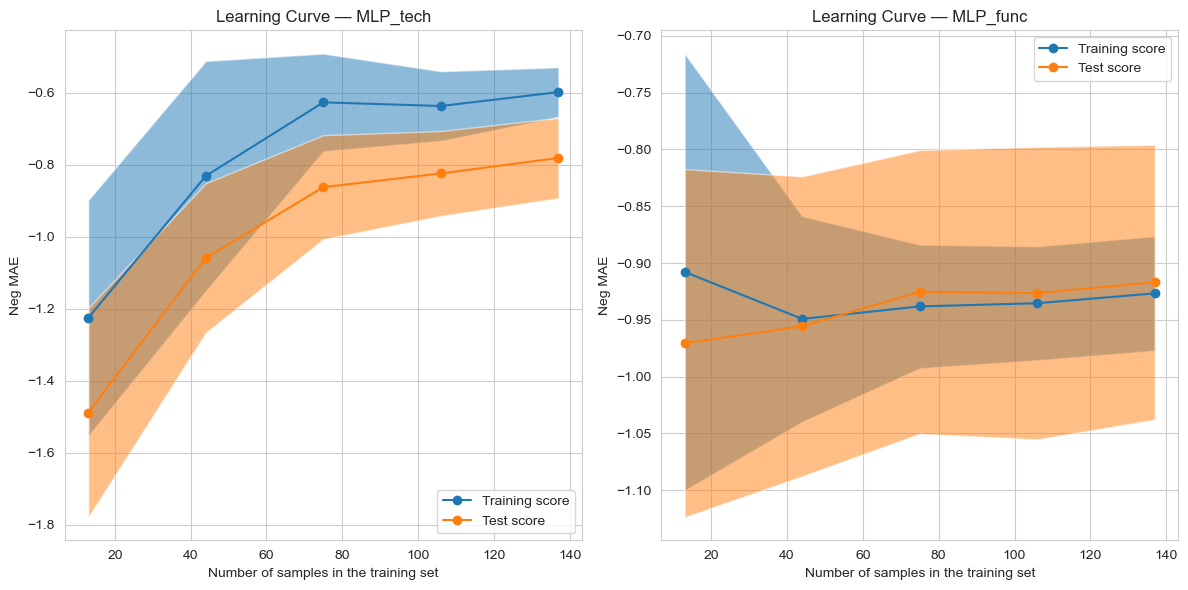

In [41]:
from sklearn.model_selection import LearningCurveDisplay, ShuffleSplit

best_tech = grid_mlp_tech.best_estimator_
best_func = grid_mlp_func.best_estimator_

# Common settings
train_sizes = np.linspace(0.1, 1.0, 5)
cv = ShuffleSplit(n_splits=50, test_size=0.2, random_state=42)

fig, axes = plt.subplots(1, 2, figsize=(12, 6))

common_params = {
    "train_sizes": train_sizes,
    "cv": cv,
    "scoring": "neg_mean_absolute_error",
    "n_jobs": -1,
    "line_kw": {"marker": "o"},
    "std_display_style": "fill_between",
    "score_type": "both",        # plot train & test
    "score_name": "Neg MAE",     # label in legend
}

# Left: tech‐only MLP
LearningCurveDisplay.from_estimator(
    best_tech,
    X=X_train_tech,
    y=y_train_log,
    **common_params,
    ax=axes[0]
)
axes[0].legend(["Training score", "Test score"])
axes[0].set_title("Learning Curve — MLP_tech")

# Right: func‐only MLP
LearningCurveDisplay.from_estimator(
    best_func,
    X=X_train_func,
    y=y_train_log,
    **common_params,
    ax=axes[1]
)
axes[1].legend(["Training score", "Test score"])
axes[1].set_title("Learning Curve — MLP_func")

plt.tight_layout()

plt.savefig("./res/plots/LearningCurveMLP.png")
plt.show()

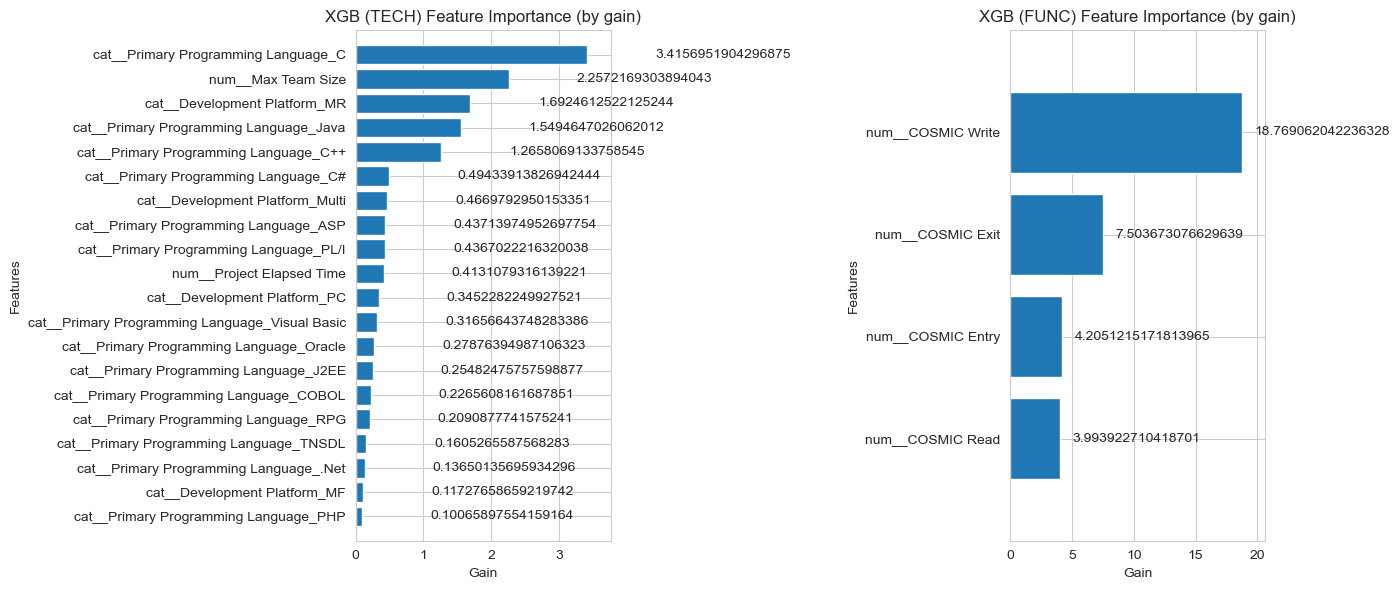

In [42]:
from xgboost import plot_importance, plot_tree
import matplotlib.pyplot as plt

# Create a 1×2 grid of axes
fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharey=False)

# Left: TECH model
plot_importance(
    best_xgb_tech,
    ax=axes[0],
    importance_type='gain',    # average gain of splits
    max_num_features=20,       # show top 20 features
    height=0.8,                # bar height
)
axes[0].set_title("XGB (TECH) Feature Importance (by gain)")
axes[0].set_xlabel("Gain")
axes[0].set_ylabel("Features")

# Right: FUNC model
plot_importance(
    best_xgb_func,
    ax=axes[1],
    importance_type='gain',
    max_num_features=20,
    height=0.8,
)
axes[1].set_title("XGB (FUNC) Feature Importance (by gain)")
axes[1].set_xlabel("Gain")

plt.tight_layout()
plt.savefig("./res/plots/XGBFeatureImportance.png")
plt.show()


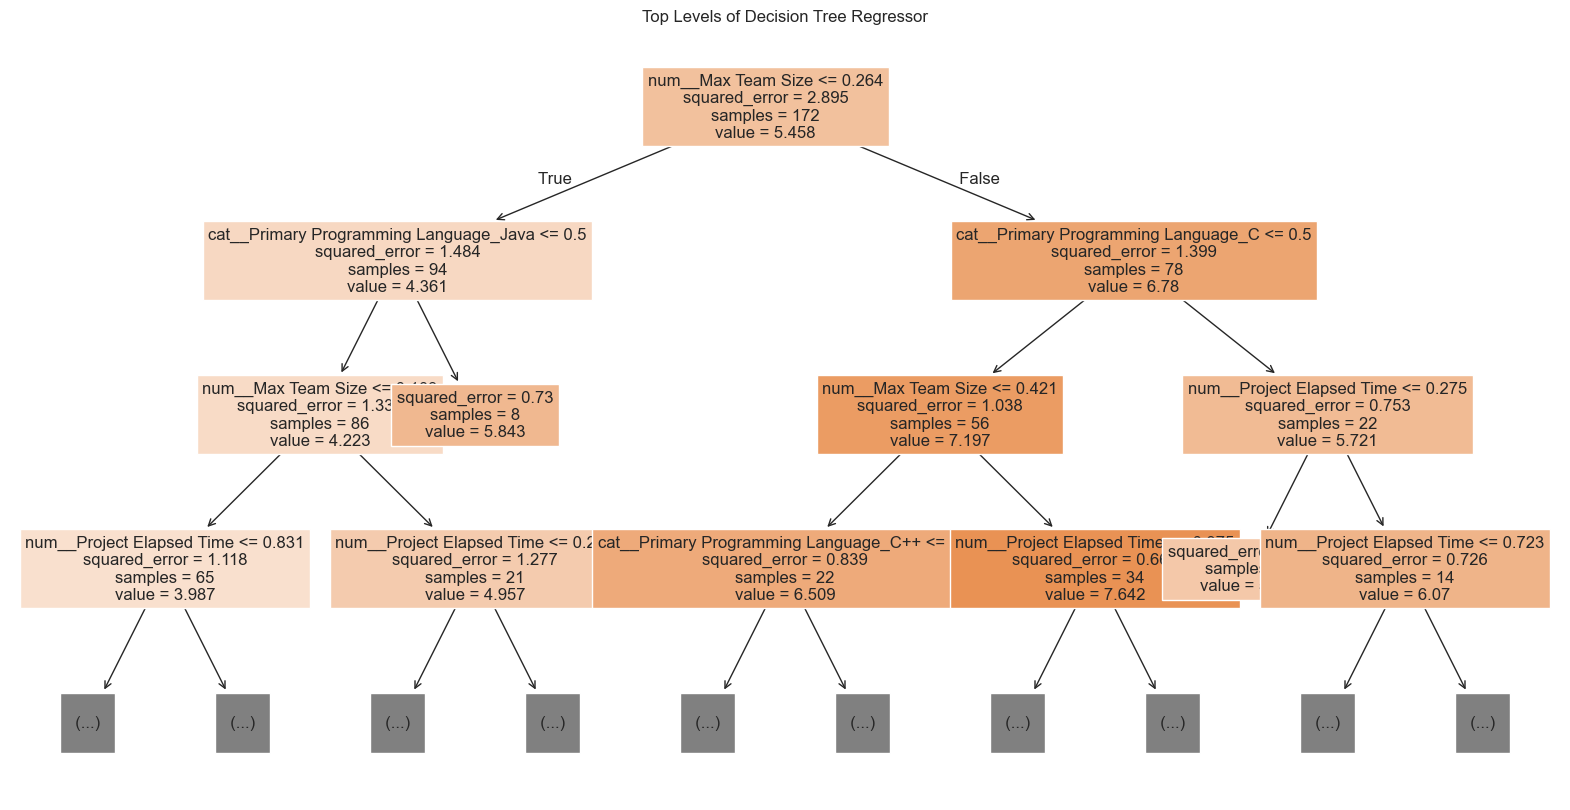

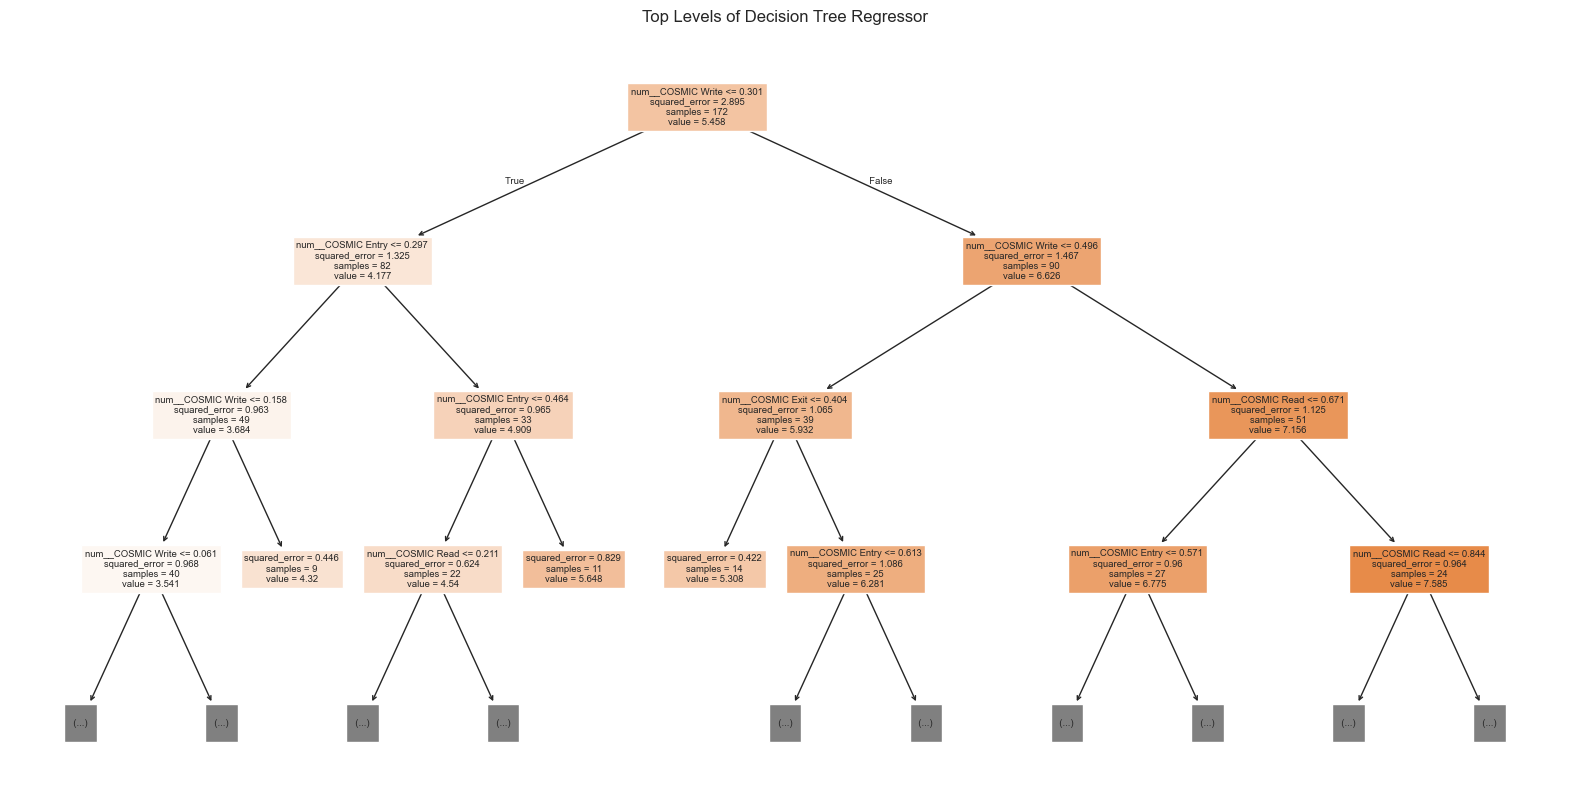

In [43]:
from sklearn import tree

fig, ax = plt.subplots(figsize=(20, 10))
tree.plot_tree(
    best_dtr_tech,
    feature_names=best_dtr_tech.feature_names_in_,
    filled=True,         # color nodes by target value
    max_depth=3,
    fontsize= 12,
    ax=ax
)
plt.title("Top Levels of Decision Tree Regressor")
plt.savefig("./res/plots/DTRfuncTree.png")
plt.show()
fig, ax = plt.subplots(figsize=(20, 10))
tree.plot_tree(
    best_dtr_func,
    feature_names=best_dtr_func.feature_names_in_,
    filled=True,         # color nodes by target value
    max_depth=3,         # show only top 3 levels for clarity
    ax=ax
)
plt.title("Top Levels of Decision Tree Regressor")
plt.savefig("./res/plots/DTRfuncTree.png")
plt.show()

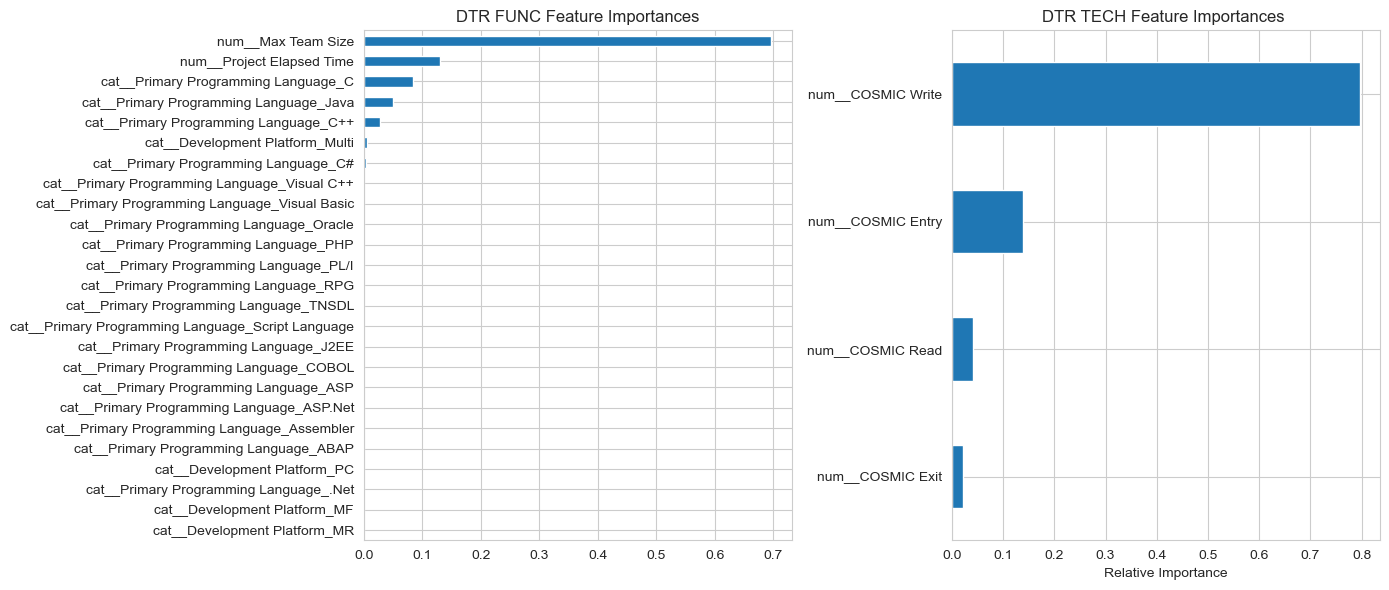

In [44]:
import pandas as pd
import matplotlib.pyplot as plt
imp_func = (
    pd.Series(best_dtr_func.feature_importances_, index=X_train_func.columns)
      .sort_values(ascending=True)
)
imp_tech = (
    pd.Series(best_dtr_tech.feature_importances_, index=X_train_tech.columns)
      .sort_values(ascending=True)
)

# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharey=False)

#  func importances
imp_func.plot.barh(ax=axes[1])
axes[0].set_title("DTR FUNC Feature Importances")
axes[0].set_xlabel("Relative Importance")

#  tech importances
imp_tech.plot.barh(ax=axes[0])
axes[1].set_title("DTR TECH Feature Importances ")
axes[1].set_xlabel("Relative Importance")

plt.tight_layout()
plt.savefig("./res/plots/DTRFeatureImportance.png")
plt.show()


Using 172 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.
100%|██████████| 172/172 [00:25<00:00,  6.85it/s]


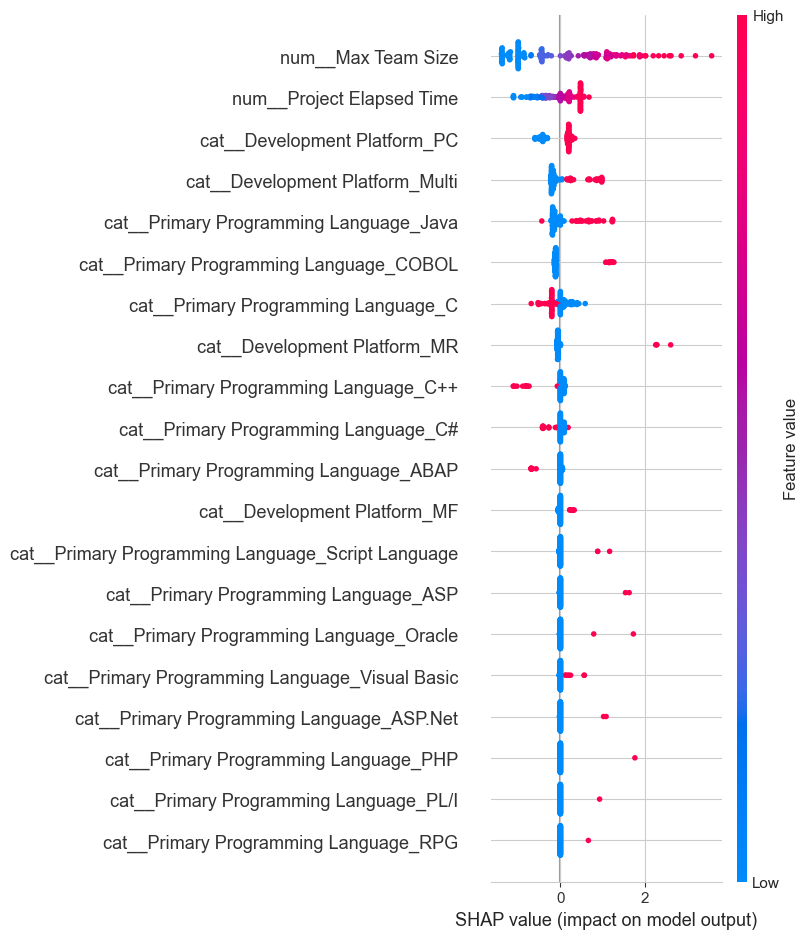

In [45]:
import shap

# fit a SHAP explainer on the tech MLP

explainer_tech = shap.KernelExplainer(best_mlp_tech.predict, X_train_tech.values)
shap_values_tech = explainer_tech.shap_values(X_train_tech.values)

# summary plot (global view)
shap.summary_plot(shap_values_tech, X_train_tech, title="Shap values MLP TECH")


Using 172 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.
100%|██████████| 172/172 [00:00<00:00, 364.85it/s]


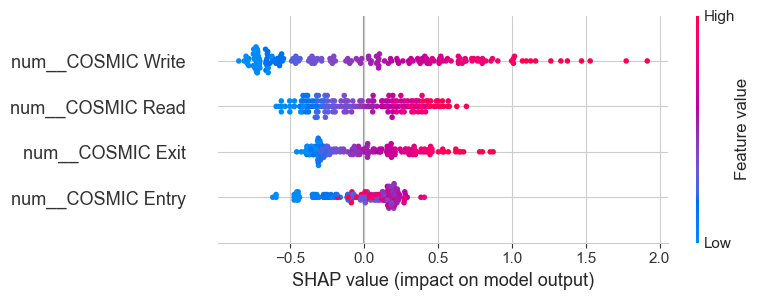

In [46]:

explainer_func = shap.KernelExplainer(best_mlp_func.predict, X_train_func.values)
shap_values_func = explainer_func.shap_values(X_train_func.values)

shap.summary_plot(shap_values_func, X_train_func, title="Shap values MLP FUNC")


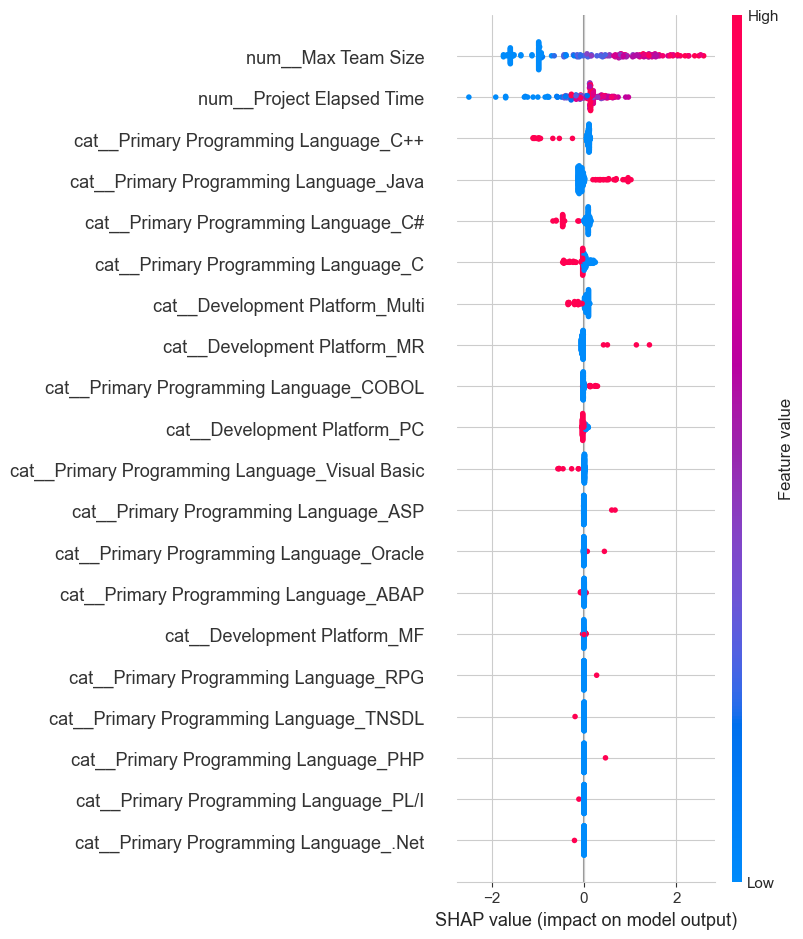

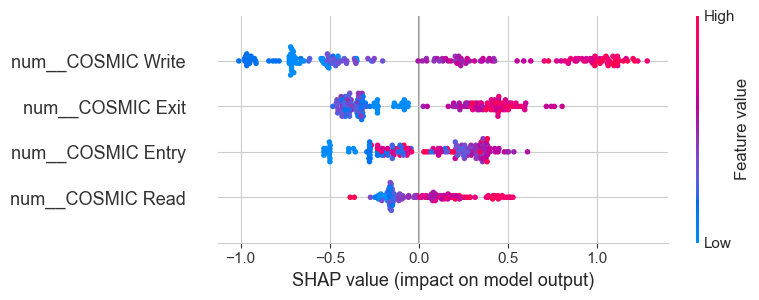

In [47]:

explainer_tech = shap.TreeExplainer(best_xgb_tech, X_train_tech.values)
shap_values_tech = explainer_tech.shap_values(X_train_tech.values)
shap.summary_plot(shap_values_tech, X_train_tech, title="Shap values XGB TECH")

explainer_func = shap.TreeExplainer(best_xgb_func, X_train_func.values)
shap_values_func = explainer_func.shap_values(X_train_func.values)
shap.summary_plot(shap_values_func, X_train_func, title="Shap values XGB FUNC")

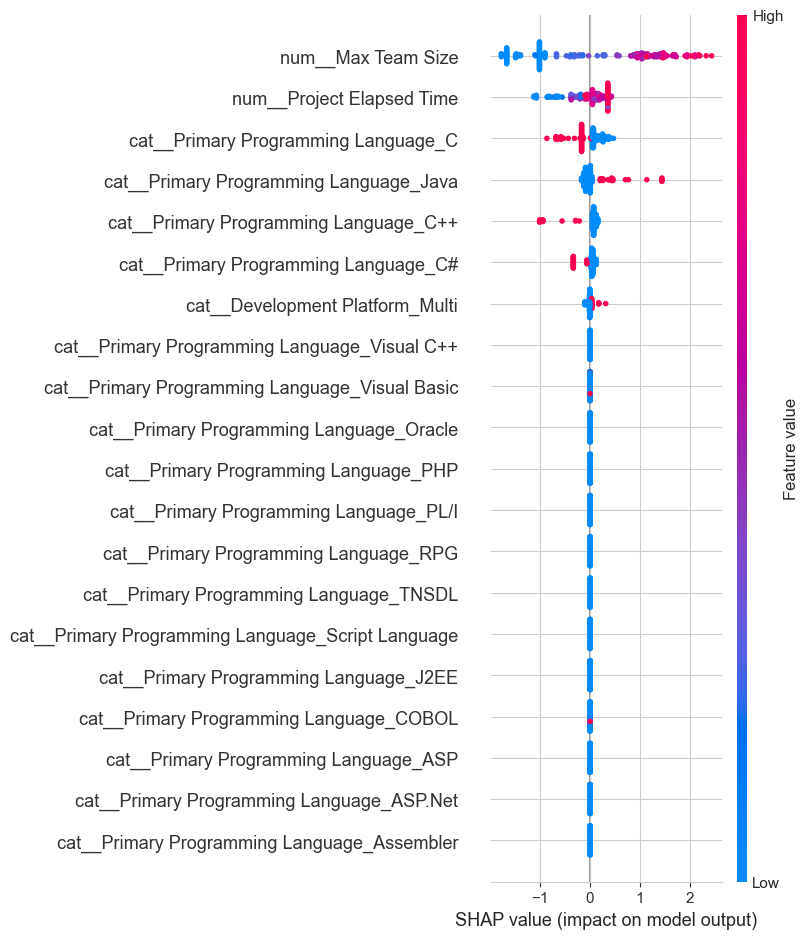

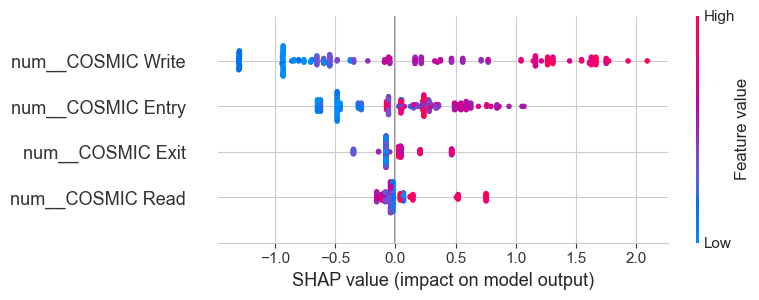

In [48]:

explainer_tech = shap.TreeExplainer(best_dtr_tech, X_train_tech.values)
shap_values_tech = explainer_tech.shap_values(X_train_tech.values)
shap.summary_plot(shap_values_tech, X_train_tech, title="Shap values DTR TECH")

explainer_func = shap.TreeExplainer(best_dtr_func, X_train_func.values)
shap_values_func = explainer_func.shap_values(X_train_func.values)
shap.summary_plot(shap_values_func, X_train_func, title="Shap values DTR FUNC")

In [49]:
from xgboost import plot_tree
import graphviz
plot_tree(best_xgb_func)

ModuleNotFoundError: No module named 'graphviz'